In [2]:
from sys import path
path.append("..")

import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdd import measures
from rdd import RDD
from rdd import visualize
from rdd import other_sims
from rdd import ascos
from rdd import cos_sim
from rdd.utils import df_to_cluster_list
from rdd.other_sims import kmeans2, kmedoid_clustering2, simrank


In [22]:
G1, G2 = nx.Graph(), nx.Graph()

G1.add_edges_from([
    (1, 2),
    (2, 3),
    (2, 4),
    (3, 4),
    (3, 6),
    (4, 5),
])

G2.add_edges_from([
    (1,2),
    (2,4),
    (2,3),
    (3,5),
    (4,5),
    (5,6)
])

# G2.add_edges_from([
#     (5, 2),
#     (2, 3),
#     (2, 4),
#     (3, 4),
#     (3, 6),
#     (4, 1),
# ])


G3 = nx.read_adjlist('../data/facebook_combined.txt', nodetype=int)
G4 = nx.read_gml('../data/karate.gml', label='id')

real_paths1 = nx.single_source_shortest_path(G3, 1, 2)
node_list1 = RDD.populate_node_list(real_paths1)
list_of_nodes = []
for node in node_list1:
    list_of_nodes.append(node.name)
G5 = RDD.nodes_to_graph(G3, list_of_nodes)
G6 = nx.read_gml('../data/lesmiserables.gml')
G7 = nx.read_adjlist('../data/Cattle_protein_interactions_(IntAct).txt')
G8 = nx.read_adjlist('../data/rat_protein_interactions_(IntAct).txt')

target_G = G4
target_rad = 2
measure_list = measures.global_graph_morgan_index

pos = nx.spring_layout(target_G)

In [23]:
def get_df_for_cluster(g):
    all_rdds_df = pd.DataFrame() 

    for target_one in g.nodes():
        rdd_list = []
        for target_two in g.nodes():
            rdd_list.append(RDD.realworld_distance_compare(target_G, target_one, target_two, measure_list, target_rad))
        all_rdds_df[target_one] = rdd_list
    
    return all_rdds_df



In [24]:
from sklearn_extra.cluster import KMedoids

cluster_df = get_df_for_cluster(target_G)
np_of_rdds = np.array(cluster_df)
kmedoids = KMedoids(n_clusters=2, random_state=0).fit(np_of_rdds)
kmedoids.labels_

array([0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])

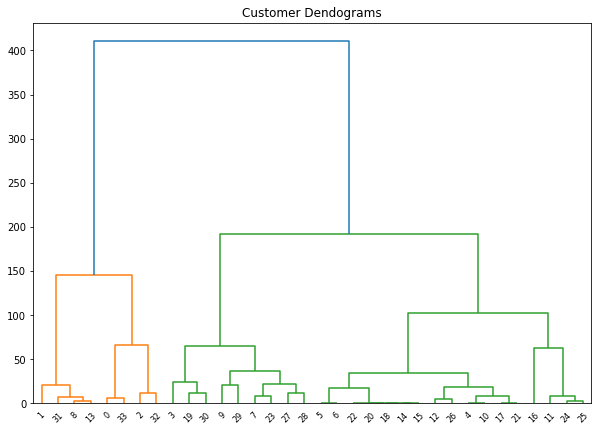

In [25]:
import scipy.cluster.hierarchy as shc

data = get_df_for_cluster(target_G)
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(data, method='ward'))

In [26]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(data)

array([1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [27]:
other_sims.agglomerative_hierarchical_clustering(target_G, target_rad, measure_list, 3)

,node_name,radius,degree,cluster
0,1,1,16,0
1,2,1,9,0
2,3,1,10,0
3,4,1,6,2
4,5,1,3,1
5,6,1,4,1
6,7,1,4,1
7,8,1,4,2
8,9,1,5,0
9,10,1,2,2


# Clusters based of distance matrixs

In [28]:
tareget_nodes = []
target_node = 1
# target_node = "Valjean"
# target_node = "CD44_BOVIN"
# fig = visualize.draw(G4, pos)
fig = visualize.visualize_rdd_vector(target_G, target_node, target_rad, pos, [measures.global_graph_degree])
visualize.add_markers(fig, tareget_nodes)
fig.show()

In [29]:
target_clusters = 5
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 200)

In [30]:
%%timeit -n1 -r1
df = other_sims.kmedoid_clustering2(target_G, RDD.get_rdd_matrix(target_G, target_rad, measures.global_graph_degree), target_clusters)
fig = visualize.visualize_rdd_kmedoid(target_G, target_rad, measure_list, pos, target_clusters)
fig.show()
df = df.sort_values('cluster')
# print(df)1

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)


-0.03476331360946731
929 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [31]:
%%timeit -n1 -r1
df = other_sims.agglomerative_hierarchical_clustering(target_G,target_rad, measures.global_graph_degree, target_clusters)
fig = visualize.visualize_rdd_agglomerative_hierarchical_clustering(target_G, target_rad, measure_list, pos, target_clusters)
fig.show()
df = df.sort_values('cluster')
# print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)

-0.09188034188034186
873 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [32]:
%%timeit -n1 -r1
df = other_sims.k_means_matrix_clustering(target_G, target_rad, [measures.global_graph_degree], target_clusters)
fig = visualize.visualize_rdd_kmeans_matrix(target_G, target_rad, [measure_list], pos, target_clusters)
fig.show()
df = df.sort_values('cluster')
# print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)


-0.07790927021696249
900 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [33]:
for k in range(1, 10, 1):
    df = other_sims.kmedoid_clustering2(target_G, RDD.get_rdd_matrix(target_G, target_rad, measures.global_graph_degree), k)
    df = df.sort_values('cluster')
    clusters = df_to_cluster_list(df)
    result = nx.algorithms.community.modularity(target_G, clusters)
    print(result)


2.846725704167068e-18
-0.01849112426035464
-0.03558514135437207
-0.03476331360946722
-0.03476331360946731
-0.03476331360946731
-0.03476331360946731
-0.03476331360946731
-0.0137245233399078


# Clustoring on a list of rdds obtained from single root node (target_node = 1) to all others

In [16]:
%%timeit -n1 -r1
df = RDD.get_rdds_for_visuals_vector(target_G, target_node, [measures.global_graph_degree], target_rad)
df = other_sims.k_means(df, [measures.global_graph_degree], target_clusters)
fig = visualize.visualize_rdd_vector_kmeans(target_G, target_node, target_rad, [measure_list], pos, target_clusters)
fig.show()
df = df.sort_values('cluster')
#print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)


-0.07708744247205764
98.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [17]:
%%timeit -n1 -r1
df = RDD.get_rdds_for_visuals_vector(target_G, target_node, [measure_list], target_rad)
df = other_sims.mean_shift(df, [measures.global_graph_degree])
fig = visualize.visualize_rdd_vector_mean_shift(target_G, target_node,target_rad, [measure_list], pos)
fig.show()
df = df.sort_values('cluster')
#print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)

-0.08390861275476659
151 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# ASCOS TESTS

In [18]:
nodes, sims = ascos.ascos(target_G)
df = other_sims.k_means_matrix(target_G, sims, target_clusters)
df = df.sort_values('cluster')
#print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)

0.396860618014463


In [19]:
nodes, sims = ascos.ascos(target_G)
df = other_sims.kmedoid_clustering2(target_G, sims, target_clusters)
df = df.sort_values('cluster')
#print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)

0.3018573307034839


In [20]:
# SimRank Modularity test with KMeans_Matrix
sim = nx.simrank_similarity(target_G)
df = pd.DataFrame.from_records(sim)

all_sim_df = pd.DataFrame() 
for node in target_G:
    list_of_sim = []
    for node2 in target_G:
        list_of_sim.append(sim[node][node2])
    all_sim_df[node] = list_of_sim

df = other_sims.k_means_matrix(target_G, all_sim_df, target_clusters)
df = df.sort_values('cluster')
#print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)

0.10174227481919798


In [21]:
# SimRank Modularity test with KMedoids_Matrix
sim = nx.simrank_similarity(target_G)
df = pd.DataFrame.from_records(sim)

all_sim_df = pd.DataFrame() 
for node in target_G:
    list_of_sim = []
    for node2 in target_G:
        list_of_sim.append(sim[node][node2])
    all_sim_df[node] = list_of_sim

df = other_sims.kmedoid_clustering2(target_G, all_sim_df, target_clusters)
df = df.sort_values('cluster')
#print(df)

clusters = df_to_cluster_list(df)
result = nx.algorithms.community.modularity(target_G, clusters)
print(result)

0.036324786324786515
